# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science 

## Lab 4: Feature Engineering and Pipelines

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb<br/>
<hr style='height:2px'>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer 
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from pandas.api.types import CategoricalDtype 
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

## ⚽💰 Can we predict the "market value" of prospective players in the Fantasy Premier League?

Table of Contents:
- Inspecting the dataset
    - Selecting relevant predictors
- Pre-processing
    - One-hot Encoding of Categorical Variables
    - Scaling of Quantitative Variables (Standardization)
- Feature Engineering
    - Polynomial and Interaction Terms
- Train-Val-Test Split
    - Stratified splitting
- Modeling
    - Multi-Linear Regression
    - KNN

**The Story**

Once Upon a Time, the Football Association gave us a dataset and asked us to help them predict the <b>market value</b> (what the player could earn when hired by a new team) of prospective players.

**The dataset**

The dataset includes data up to 2017, and was created by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) who used a variety of sources, including *transfermrkt.com* and *Fantasy Premier League (FPL)*, and a variety of methods, including scraping. 
Each observation is a collection of facts about players in the English Premier League. 

`name`             : Name of the player  
`club`             : Club of the player  
`age`              : Age of the player  
`position`         : The usual position on the pitch  
`position_cat`     : 1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers   
`page_views`       : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_points`       : FPL points accumulated over the previous season (https://www.premierleague.com/news/2174909)<BR>
`region`           : 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`      : Player's nationality <BR>
`new_signing`      : Whether a new signing for 2017/18 (till 20th July)  
`new_foreign`      : Whether a new signing from a different league, for 2017/18 (till 20th July)  
`club_id`          : a numerical version of the Club feature  

### Our goal
To construct and fit a model that predicts the players' `market value` using all or part of the features in the given data.

### Our return variable

`market_value`: As on transfermrkt.com on July 20th, 2017 in £M (British pounds)
    

### Inspect the Data

In [2]:
df = pd.read_csv("data/league_data.csv")
df_original = df.copy() # to recover later
df.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2,Germany,0,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,134,2,Czech Republic,0,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,122,1,England,0,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,121,2,France,0,1,0


### Feature Engineering

#### 'Big Club'

The Football Association have a hunch that being in a **big club** affects the market value of a player, so they want us to construct and include this feature in our model. We also noticed that `club_id` had 20 categories which may be more than we might want to one-hot-encode due to the small amount of training data and the increased risk overfitting that comes with more features.
<BR><BR>
Until 2017, big clubs were the following:
<BR>
    
```
'Arsenal', 'Chelsea', 'Liverpool', 'Manchester+City', 'Manchester+United', 'Tottenham'
```

**Create a new binary categorical variable named `big_clubs` with values $1$ if a club belongs to the Top 6 clubs and $0$ otherwise.**

In [3]:
# We can teach the model to identify big clubs, instead of letting it try to figure it out on its own
big_clubs = ['Arsenal', 'Chelsea',
             'Liverpool', 'Manchester+City',
             'Manchester+United', 'Tottenham']

df['big_club'] = df.club.isin(big_clubs).astype(int)
# df['big_club'] = df.club.isin(big_clubs).map({True: 1, False: 0}).astype(int)
# True is 1, False is 0 -> can use the map function to convert the boolean values if needed

In [4]:
# check
# Check out your new `big_club` feature!
df.head(2)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing,big_club
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0,1
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2,Germany,0,1,0,1


**Does being in a big club affect market value?**

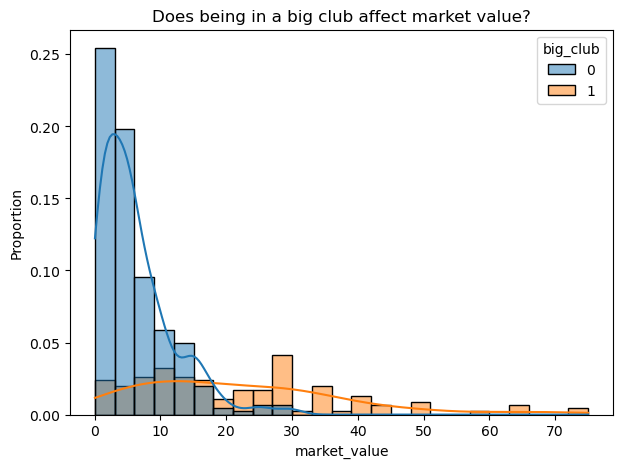

In [6]:
plt.figure(figsize=(7,5))
ax = sns.histplot(data=df, x='market_value', hue='big_club', stat='proportion', kde=True)
ax.set_title("Does being in a big club affect market value?");
# works on an axes object

#### Select Relevant Features and Fit a Model!

Right now we really only have the means to make use of the quantitative and binary features. We'll resolve that soon enough. But let's see how well we can do with just these:
1. Select some relevant features you think may help predict the market price (feel free to also hand-engineer some additional features like we did with `big_club`)
2. Separate your features, `X`, from the response, `y`
3. Perform a `test_train_split` with 20% going to test and a `random_state` of 42
4. Fit your model and check the training MSE and $R^2$, iterate if you need to
5. When you are satisfied, report the test MSE and $R^2$

How well did you do? It is important to avoid the temptation to peek at the test score to inform your model selection!

In [7]:
df.head(1)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing,big_club
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0,1


In [27]:
# Select relevant features (quantitative and binary)
df['age_squared'] = df['age'] ** 2
features = ['age', 'page_views', 'fpl_points', 'new_foreign', 'new_signing', 'big_club', 'age_squared']
response = 'market_value'

In [28]:
# Split the data into features (X) and target (y)
X = df[features]
y = df[response]
X.shape, y.shape

((460, 7), (460,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((368, 7), (92, 7), (368,), (92,))

In [25]:
lr = LinearRegression().fit(X_train, y_train)

In [26]:
print('Train: ',mean_squared_error(y_train, lr.predict(X_train)), lr.score(X_train, y_train))
print('Test: ',mean_squared_error(y_test, lr.predict(X_test)), lr.score(X_test, y_test))

Train:  37.16667284512503 0.737821395468817
Test:  34.20448289073941 0.8139457098436255


In case we made other changes to our dataframe before fitting the above model, let's revert back to the original data plus our big_clubs feature.

In [9]:
df = df_original.copy()
df['big_club'] = df.club.isin(big_clubs).astype(int)

#### One-hot Encoding of Categorical Variables

Before we can move on to modeling, all predictors we'd like to use must be represented numerically. Some of our predictors, like `nationality`, are currently encoded as strings. Others, like `region` are currently encoded as integers but are actually categorical.

We should identify all categorical columns and then *one-hot encode* them. That is, a categorical feature column with N categories should be converted to N-1 binary and mutually exclusive columns. Having a $1$ in the 1st column corresponds to an observation belonging to the 1st class, a $1$ in the 2nd column if it belongs to the 2nd class, and so on. Having all N-1 columns set to $0$ corresponds to belonging to the N-th class. In this way, N-1 binary features can be used to represent N different classes. 

The first step is to designate a list of `categorical_cols` which we would like to encode/

In [29]:
# do not forget to add 'big_club' to our features
# remove
categorical_cols = ['position_cat', 'new_signing', 'big_club', 'region'] 

Doing the encoding 'by hand' would be a pain. Luckily, we have a few options.

##### Pandas `get_dummies`

The Pandas `get_dummies` function makes one-hot encoding very easy. We just need to specify which columns are to be encoded with the `columns` argument.

By default, this method does *not* drop one of the resulting N columns and their values are encoded as booleans. We can tweak this behavior using the `drop_first` and `dtype` arguments.

In [30]:
pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int).head() 
# you only need N-1 columns to get N dummy variables
# can specify dtype; default is boolean

,name,club,age,position,market_value,page_views,fpl_points,nationality,new_foreign,club_id,age_squared,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,Alexis Sanchez,Arsenal,28,LW,65.0,4329,264,Chile,0,1,784,0,0,0,0,1,0,1,0
1,Mesut Ozil,Arsenal,28,AM,50.0,4395,167,Germany,0,1,784,0,0,0,0,1,1,0,0
2,Petr Cech,Arsenal,35,GK,7.0,1529,134,Czech Republic,0,1,1225,0,0,1,0,1,1,0,0
3,Theo Walcott,Arsenal,28,RW,20.0,2393,122,England,0,1,784,0,0,0,0,1,0,0,0
4,Laurent Koscielny,Arsenal,31,CB,22.0,912,121,France,0,1,961,0,1,0,0,1,1,0,0


##### SKLearn `OneHotEncoder`

**OneHotEncoder vs. pandas get_dummies**

SKLearn's OneHotEncoder and pandas' get_dummies both convert categorical variables into binary columns, but they differ in key ways:

- **OneHotEncoder** works with **numpy arrays** and can be integrated into sklearn pipelines.
- **get_dummies** operates on pandas **DataFrames** and is often used in data preprocessing outside of pipelines.
- OneHotEncoder can handle new categories at prediction time (with 'handle_unknown' parameter), while get_dummies cannot.

OneHotEncoder is particularly useful in **pipelines** because it can be applied consistently to both training and test data, ensuring the same encoding across all stages of your model.

**Sklearn Transformer API**

Sklearn's transformer API follows a consistent pattern:

- fit(X, y=None): Learns the parameters of the transformation from the data.
- transform(X): Applies the learned transformation to the data.
- fit_transform(X, y=None): Combines fit and transform in one step, often more efficient.
- get_feature_names_out(): Returns the names of the output features after transformation.

This API is similar to model fitting (fit) and prediction (transform), making it intuitive and consistent across different sklearn components.

Transformers can be used individually or as part of a pipeline, allowing for seamless integration of data preprocessing and model training steps.

In [34]:
from sklearn.preprocessing import OneHotEncoder
# you will lose column names
# can deal with new columns in test
ohe = OneHotEncoder(drop='first', sparse_output=False) # don't get sparse object
# first category gets absorbed in intercept
ohe.fit_transform(df[categorical_cols]) # changes object in place
type(ohe_matrix)
ohe.categories_

[array([1, 2, 3, 4]), array([0, 1]), array([0, 1]), array([1, 2, 3, 4])]

In [35]:
ohe_matrix.shape, df[categorical_cols].shape

((460, 8), (460, 4))

In [36]:
# get the names of the newly created variables
ohe.get_feature_names_out()

array(['position_cat_2', 'position_cat_3', 'position_cat_4',
       'new_signing_1', 'big_club_1', 'region_2', 'region_3', 'region_4'],
      dtype=object)

In [37]:
# make into Dataframe
df_ohe = pd.DataFrame(ohe_matrix, columns=ohe.get_feature_names_out())
df_ohe.head()

,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


### Scaling Numeric Features

#### Feature Scaling with StandardScaler

Feature scaling is crucial in many machine learning algorithms, particularly for:

- Polynomial models: Scaling prevents under- and over-flow problems when taking predictors to high degrees.
- kNN models: Scaling ensures all features contribute equally to distance calculations, preventing features with larger scales from dominating.

**Why Scaling Matters**
- Improves convergence speed for gradient-based algorithms (less of a concern for us now)
- Ensures features contribute proportionally to the model, based on their information content rather than their scale.

**inverse_transform Method**
The inverse_transform method allows you to revert scaled data back to its original scale, useful for interpreting results or presenting predictions in the original units.

**Fitting Scalers: Train vs. Train+Test**
There's debate on whether to fit scalers on just the training data or both training and test:
- Fitting on train only: Prevents any information leakage from the test set (but we aren't looking at the response here anyway!)
- Fitting on train+test: Can provide a more robust scaling, especially for small datasets (Pavlos does this).

The choice often depends on the specific use case and dataset characteristics.

**Other Scaling Options in sklearn**
Besides StandardScaler, sklearn offers several other scaling methods:
- MinMaxScaler: Scales features to a fixed range, usually [0, 1].
- RobustScaler: Uses statistics that are robust to outliers.
- Normalizer: Scales individual samples to have unit norm.
- QuantileTransformer: Transforms features to follow a uniform or normal distribution.

Each scaler has its strengths and is suited for different types of data and models.

In [39]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ['page_views', 'fpl_points', 'age'] 

scaler = StandardScaler().fit(df[numerical_cols])

In [40]:
# Mean and stdev are recorded after the fit
scaler.mean_, scaler.scale_

(array([764.6       ,  57.33695652,  26.81086957]),
 array([931.63801797,  53.1116292 ,   3.95972816]))

In [44]:
# Transforming gives us a numpy array
scaled_matrix = scaler.transform(df[numerical_cols])
scaled_matrix

array([[ 3.82594949,  3.89110721,  0.30030608],
       [ 3.89679246,  2.0647652 ,  0.30030608],
       [ 0.82049035,  1.44343234,  2.0681042 ],
       ...,
       [-0.60817613, -0.53353582, -0.96240687],
       [-0.37847318, -0.7783033 , -1.46749204],
       [-0.59100207, -0.85361638,  0.04776349]])

In [45]:
# We can always convert back to the original scale to intepret things
scaler.inverse_transform(scaled_matrix)

array([[4329.,  264.,   28.],
       [4395.,  167.,   28.],
       [1529.,  134.,   35.],
       ...,
       [ 198.,   29.,   23.],
       [ 412.,   16.,   21.],
       [ 214.,   12.,   27.]])

In [46]:
# But we've lost the column names!
# Luckily, there is a method for getting them back
df_scaled = pd.DataFrame(scaled_matrix, columns=scaler.get_feature_names_out())
df_scaled.head()

,page_views,fpl_points,age
0,3.825949,3.891107,0.300306
1,3.896792,2.064765,0.300306
2,0.820490,1.443432,2.068104
3,1.747889,1.217493,0.300306
4,0.158216,1.198665,1.057934


#### Polynomial and Interaction Terms

#### PolynomialFeatures in sklearn

PolynomialFeatures is a preprocessing tool that helps us create polynomial and interaction features.

**Key Parameters:**

- `degree`: Controls the maximum degree of the polynomial features.
- `include_bias`: Adds a bias (constant) term.
   - Default is True, adding a column of 1s.
   - **Caution:** When True, this can cause issues with linear regression models that already fit an intercept, leading to multicollinearity.
   - Best practice: Set include_bias=False when using with sklearn's linear models.
- `interaction_only`: If True, only interaction features are produced.


**Note on Interactions vs. Pure Polynomials:**

While you can get only interaction terms (interaction_only=True), there's no built-in way to get only polynomial terms without interactions. If needed, you'd have to create a custom transformer or manually select the desired features after transformation.

In [47]:
# Import Polynomial Features, 'fit' it with degree 2, and get the feature names out
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False) # includes degree 0 -> LinearRegression already has a column of 1s
poly.fit(df_scaled)
poly.get_feature_names_out()

array(['page_views', 'fpl_points', 'age', 'page_views^2',
       'page_views fpl_points', 'page_views age', 'fpl_points^2',
       'fpl_points age', 'age^2'], dtype=object)

In [49]:
# We can put this back into a dataframe
df_poly = pd.DataFrame(poly.transform(df_scaled[numerical_cols]), columns=poly.get_feature_names_out())
df_poly.head()

,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2
0,3.825949,3.891107,0.300306,14.637890,14.887180,1.148956,15.140715,1.168523,0.090184
1,3.896792,2.064765,0.300306,15.184991,8.045961,1.170230,4.263255,0.620062,0.090184
2,0.820490,1.443432,2.068104,0.673204,1.184322,1.696860,2.083497,2.985168,4.277055
3,1.747889,1.217493,0.300306,3.055117,2.128043,0.524902,1.482290,0.365621,0.090184
4,0.158216,1.198665,1.057934,0.025032,0.189648,0.167382,1.436797,1.268108,1.119224


In [50]:
# We now have our processed quantitative and categorical features
df_scaled.shape, df_ohe.shape

((460, 3), (460, 8))

In [51]:
# Concatenating this back with the OHE features gives us the full design matrix
df_design = pd.concat([df_poly, df_ohe], axis=1)
df_design.head()

,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,3.825949,3.891107,0.300306,14.637890,14.887180,1.148956,15.140715,1.168523,0.090184,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,3.896792,2.064765,0.300306,15.184991,8.045961,1.170230,4.263255,0.620062,0.090184,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.820490,1.443432,2.068104,0.673204,1.184322,1.696860,2.083497,2.985168,4.277055,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1.747889,1.217493,0.300306,3.055117,2.128043,0.524902,1.482290,0.365621,0.090184,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.158216,1.198665,1.057934,0.025032,0.189648,0.167382,1.436797,1.268108,1.119224,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


#### SKLearn Pipelines

##### Pipelines and Custom Transformers in sklearn

**Pipelines**

Pipelines in sklearn are a powerful tool for chaining multiple steps of data processing and modeling. They offer several advantages:

- Simplification: Combine preprocessing, feature selection, and modeling in a single object.
- Consistency: Apply the same steps to training and test data, preventing data leakage.
- Convenience: Fit and predict on the entire workflow with a single call.
- Grid Search: Easily perform cross-validation across all parameters in the pipeline.

Example of a basic pipeline:
```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
```

**Custom Transformers**

While sklearn provides many built-in transformers, you can create custom transformers to extend functionality:

- Implement specific data transformations not available in sklearn.
- Encapsulate domain-specific feature engineering.
- Ensure your custom preprocessing steps integrate seamlessly with sklearn pipelines.

To create a custom transformer, implement a class with fit(), transform(), and fit_transform() methods:

```python
from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Perform any necessary computation
        return self

    def transform(self, X):
        # Transform the data
        return X_transformed

# Use in a pipeline
pipeline = Pipeline([
    ('custom', CustomTransformer()),
    ('model', SomeModel())
])
```

Custom transformers allow you to incorporate any data processing logic into your machine learning workflow, making pipelines extremely flexible and powerful.

Below we've created a custom transformer to give us *only* polynomial features without interaction terms.

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom Polynomial Transformer (without interaction terms)
class CustomPolynomialTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2):
        self.degree = degree
    
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self
    
    def transform(self, X):
        X_poly = [X]
        for d in range(2, self.degree + 1):
            X_poly.append(X ** d)
        return np.column_stack(X_poly)

    def get_feature_names_out(self, input_features=None):
        """Get output feature names for transformation."""
        if input_features is None:
            input_features = [f"x{i}" for i in range(self.n_features_in_)]
        elif len(input_features) != self.n_features_in_:
            raise ValueError("input_features should have length equal to number of features.")
        
        feature_names = []
        for feature in input_features:
            feature_names.extend([f"{feature}^{d}" for d in range(1, self.degree + 1)])
        
        return np.array(feature_names, dtype=object)

#### Preprocessing Pipeline Description

The pipeline below is designed to handle both our numeric and categorical features, creating polynomial terms and interactions:

1. ColumnTransformer ('preprocessor'):
   - Applies different transformations to numeric and categorical features.
   - For numeric features: Standardizes and creates polynomial terms (up to degree 2).
   - For categorical features: Performs one-hot encoding.

2. PolynomialFeatures ('interaction'):
   - Creates interaction terms between all features after initial preprocessing.
   - Only generates interactions (interaction_only=True), not additional polynomial terms.

The pipeline ensures consistent application of these steps to both training and test data, preventing data leakage and simplifying the workflow. It combines feature scaling, polynomial feature creation, categorical encoding, and interaction term generation in a single, reusable object.

In [53]:
# Creating the Preprocessing Pipeline
numeric_features = ['age', 'page_views', 'fpl_points']
categorical_features = ['position_cat', 'region', 'club_id', 'new_foreign', 'new_signing']
degree = 2

# Numeric features pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', CustomPolynomialTransformer(degree=degree))
])

# Categorical features pipeline
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Add interaction terms
interaction_transformer = PolynomialFeatures(interaction_only=True, include_bias=False)

In [54]:
# Putting it all together
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('interaction', interaction_transformer),
])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   CustomPolynomialTransformer())]),
                                                  ['age', 'page_views',
                                                   'fpl_points']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['position_cat', 'region',
                                                   'club_id', 'new_foreign',
                                                   'new_signing'])])),
                ('interaction',
                 PolynomialFeatures(include_bias=False,
                                    interaction_only=True))])

### Train-Validation-Test Spit with Stratification

**Stratification** in data splitting ensures that the distribution of the target variable (market value) is similar across train, validation, and test sets. We bin the target values to create balanced strata, which helps maintain representative subsets for model training and evaluation. It is also possible to stratify on predictor variables.

In our example below, the y_bins are split alongside X and y to maintain consistent stratification across multiple splits. In the first split, y_bins ensures the test set is representative. In the second split, y_bins_train_val is used to further stratify the training and validation sets. This approach preserves the distribution of the target variable across all subsets, ensuring each is representative of the original data distribution.

In [55]:
# Prepare the features (X) and target variable (y)
X = df.drop('market_value', axis=1)
y = df['market_value']

# Create bins for stratification
y_bins = pd.cut(y, bins=5, labels=False)

# Perform stratified split
X_train_val, X_test, y_train_val, y_test, y_bins_train_val, y_bins_test = train_test_split(
    X, y, y_bins, test_size=0.2, stratify=y_bins, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_bins_train_val, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (276, 14)
Validation set shape: (92, 14)
Test set shape: (92, 14)


Later, once we've selected the best model using the validation set, we will *refit it on the combined training and validation data*. This approach maximizes the use of available data for the final model, potentially improving its performance and generalization ability. The test set remains untouched until final evaluation, providing an unbiased assessment of the model's performance on unseen data. 

For this reason, it is nice to keep variables from the first split that contains both the train and validation data (we call them `X_train_val` and `y_train_val`. Of course, you could always simply concatenate the train and validation sets back together.

OK, let's try fitting on our design matrix from the pipeline!

In [29]:
pipe.fit(X)
X_train_design = pipe.transform(X_train)
X_val_design = pipe.transform(X_val)
X_test_design = pipe.transform(X_test)

In [30]:
lr = LinearRegression().fit(X_train_design, y_train)
lr.score(X_train_design, y_train), lr.score(X_val_design, y_val)

In [31]:
lr.score(X_test_design, y_test)

Oops! we've clearly overfit. Perhaps a greedy, **forward-step feature selection** approach might improve things.

In [32]:
def forward_feature_selection(X, y, X_val, y_val, model, max_features=10):
    features = []
    best_score = float('-inf')
    
    while len(features) < max_features:
        best_new_feature = None
        for feature in range(X.shape[1]):
            if feature not in features:
                current_features = features + [feature]
                model.fit(X[:, current_features], y)
                score = model.score(X_val[:, current_features], y_val)
                
                if score > best_score:
                    best_score = score
                    best_new_feature = feature
        
        if best_new_feature is None:
            break
        
        features.append(best_new_feature)
        print(f"Added feature: {best_new_feature}, Score: {best_score:.4f}")
    
    return features

In [33]:
# Model selection and evaluation
model = LinearRegression()
max_features = 5

print(f"\nPerforming forward feature selection for Linear Regression:")
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('interaction', interaction_transformer)
])
X_train_processed = pipeline.fit_transform(X_train)
X_val_processed = pipeline.transform(X_val)

best_features = forward_feature_selection(X_train_processed, y_train, 
                                              X_val_processed, y_val, model,
                                              max_features=max_features)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('interaction', interaction_transformer),
    ('selector', ColumnTransformer([('selector', 'passthrough', best_features)])),
    ('model', model)
])

final_pipeline.fit(X_train, y_train)
best_score = final_pipeline.score(X_val, y_val)

best_model = final_pipeline

print(f"\nBest model: {type(best_model.named_steps['model']).__name__}")
print(f"Best validation R2 score: {best_score:.4f}")
print("Selected features:", best_features)

In [34]:
pipeline.get_feature_names_out()[best_features]

In [35]:
# Final Model Evaluation
best_model.fit(X_train_val, y_train_val)
y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\nFinal Model Performance on Test Set:")
print(f"R2 Score: {test_r2:.4f}")
print(f"Mean Squared Error: {test_mse:.4f}")

#### kNN Pipeline

Pipeline Parameter Passing:
We can set parameters for any step in the pipeline using the syntax `stepname__parameter`. In our case, we use `regressor__n_neighbors=k` to set the number of neighbors for the KNeighborsRegressor. This is a key feature that allows us to modify pipeline parameters dynamically. We can easily change the value of k without creating a new pipeline each time.

We've also created an `evaluate_knn` function that encapsulates the process of setting the k value, fitting the model, and evaluating it on both training and validation sets.

This method can easily be extended to tune multiple hyperparameters simultaneously.

In [36]:
# Create kNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

# Function to fit and evaluate the pipeline for a given k
def evaluate_knn(k, X_train, y_train, X_val, y_val):
    knn_pipeline.set_params(regressor__n_neighbors=k)
    knn_pipeline.fit(X_train, y_train)
    train_mse = mean_squared_error(y_train, knn_pipeline.predict(X_train))
    val_mse = mean_squared_error(y_val, knn_pipeline.predict(X_val))
    return train_mse, val_mse

# Fit and evaluate for different k values
k_values = range(1, 31)
train_mses = []
val_mses = []

for k in k_values:
    train_mse, val_mse = evaluate_knn(k, X_train, y_train, X_val, y_val)
    train_mses.append(train_mse)
    val_mses.append(val_mse)

In [37]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_mses, label='Training MSE')
plt.plot(k_values, val_mses, label='Validation MSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.title('kNN: Performance vs. Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

# Find best k
best_k = k_values[np.argmin(val_mses)]
print(f"Best k: {best_k}")

In [38]:
# Refit the best model on combined training and validation data
best_knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=best_k))
])
best_knn_pipeline.fit(X_train_val, y_train_val)

# Evaluate on test set
y_pred = best_knn_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance on Test Set:")
print(f"Mean Squared Error: {test_mse:.4f}")
print(f"R² Score: {test_r2:.4f}")

A sneak peak for cross-validation and regularization for next time...

In [43]:
from sklearn.model_selection import cross_val_score
import numpy as np

def forward_feature_selectionCV(X, y, model, max_features=10, cv=5):
    features = []
    best_score = float('inf')  # We're minimizing MSE
    n_features = X.shape[1]
    
    while len(features) < max_features:
        best_new_feature = None
        for i in range(n_features):
            if i not in features:
                current_features = features + [i]
                if isinstance(X, pd.DataFrame):
                    X_subset = X.iloc[:, current_features]
                else:
                    X_subset = X[:, current_features]
                
                scores = cross_val_score(model, X_subset, y, cv=cv, scoring='neg_mean_squared_error')
                score = -scores.mean()  # Convert to positive MSE
                
                if score < best_score:  # We're minimizing MSE
                    best_score = score
                    best_new_feature = i
        
        if best_new_feature is None:
            break
        
        features.append(best_new_feature)
        print(f"Added feature: {best_new_feature}, MSE: {best_score:.4f}")
    
    return features

In [44]:
# Model selection and evaluation
model = LinearRegression()
max_features = 3
cv = 7

print(f"\nPerforming forward feature selection for Linear Regression:")
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('interaction', interaction_transformer)
])

pipeline.fit(X)
X_train_val_processed = pipeline.transform(X_train_val)

best_features = forward_feature_selectionCV(X_train_val_processed,
                                                y_train_val,
                                                model, max_features=max_features,
                                                cv=5)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('interaction', interaction_transformer),
    ('selector', ColumnTransformer([('selector', 'passthrough', best_features)])),
    ('model', model)
])

final_pipeline.fit(X_train, y_train)
best_score = final_pipeline.score(X_val, y_val)
best_model = final_pipeline

print(f"Best validation R2 score: {best_score:.4f}")
print("Selected features:", pipeline.get_feature_names_out()[best_features])

In [45]:
# Final CV Model Evaluation
best_model.fit(X_train_val, y_train_val)
y_test_pred = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\nFinal Model Performance on Test Set:")
print(f"R2 Score: {test_r2:.4f}")
print(f"Mean Squared Error: {test_mse:.4f}")

In [ ]:
from sklearn.linear_model import LassoCV
# Create the full pipeline including LassoCV
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('interaction', interaction_transformer),
    ('lasso', LassoCV(cv=5, max_iter=5000, random_state=42))
])

# Fit the pipeline on the training data
lasso_pipeline.fit(X_train_val, y_train_val)

# Make predictions on the test set
y_pred = lasso_pipeline.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("LassoCV Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

print(f"Selected alpha: {lasso_pipeline.named_steps['lasso'].alpha_:.6f}")

# Print non-zero coefficients
feature_names = lasso_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names = lasso_pipeline.named_steps['interaction'].get_feature_names_out(feature_names)
lasso_coef = lasso_pipeline.named_steps['lasso'].coef_

print("\nNon-zero coefficients:")
for name, coef in zip(feature_names, lasso_coef):
    if coef != 0:
        print(f"{name}: {coef:.4f}")